## ***BRAIN TUMOR DETECTION USING ML AND CNN ALGORITHMS***

## **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Flatten,MaxPooling2D,Conv2D, BatchNormalization,Dropout,Input
from keras.models import Sequential
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from keras.optimizers import Adam

In [2]:
dataset_path = "./Tumor_Dataset"

In [3]:
# Create a dictionary to map class labels to numeric values
classes = {
    'NoTumor': 0,
    'Tumor': 1
}

# ***Data Preparation***

In [4]:
X = []  # List to store images
Y = []  # List to store corresponding labels

# Iterate through each class in the 'classes' list
for cls in classes:
    # Construct the path to the directory for the current class in the training set
    train_path = './Tumor_Dataset/Training/' + cls

    # Iterate through each file in the training directory
    for j in os.listdir(train_path):
        # Read the image in grayscale
        img = cv2.imread(os.path.join(train_path, j), 0)

        # Resize the image to (224, 224)
        img = cv2.resize(img, (224, 224))

        # Append the processed image to the 'X' list
        X.append(img)

        # Append the label corresponding to the current class to the 'Y' list
        Y.append(classes[cls])

    # Construct the path to the directory for the current class in the testing set
    test_path = './Tumor_Dataset/Training/' + cls

    # Iterate through each file in the testing directory
    for j in os.listdir(test_path):
        # Read the image in grayscale
        img = cv2.imread(os.path.join(test_path, j), 0)

        # Resize the image to (224, 224)
        img = cv2.resize(img, (224, 224))

        # Append the processed image to the 'X' list
        X.append(img)

        # Append the label corresponding to the current class to the 'Y' list
        Y.append(classes[cls])


# ***Exploratory Data Analysis***

In [5]:
# Convert lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

In [6]:
print(X.shape)

(1620, 224, 224)


In [7]:
print(Y.shape)

(1620,)


In [8]:
# Convert the NumPy array to a Pandas Series and then use value_counts
value_counts_result = pd.Series(Y).value_counts()
print(value_counts_result)

0    810
1    810
Name: count, dtype: int64


In [9]:
# Upsample the data using RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X, Y = ros.fit_resample(X.reshape(len(X), -1), Y)

# Reshape the features back to images
X = X.reshape(-1, 224, 224)

In [10]:
# Convert the NumPy array to a Pandas Series and then use value_counts
value_counts_result = pd.Series(Y).value_counts()
print(value_counts_result)

0    810
1    810
Name: count, dtype: int64


In [11]:
# Now, X and Y are NumPy arrays and can be used in NumPy operations
print(X.shape)   # Shape of the array (number of images, height, width) for example
print(Y.shape)

(1620, 224, 224)
(1620,)


In [12]:
# Y is a NumPy array containing labels
unique_labels = np.unique(Y)
print(unique_labels)

[0 1]


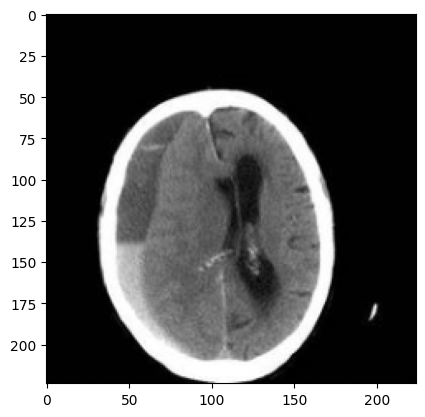

In [13]:
# Visualize the first image
plt.imshow(X[0], cmap='gray')

# ***Image Flattening***

In [14]:
# Flatten the images
X_flat = X.reshape(len(X), -1)

In [15]:
print("Original Image:")
print(X[0])
print("\nFlattened Image:")
print(X_flat[0])

Original Image:
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]

Flattened Image:
[1 1 1 ... 1 1 1]


# ***Train-Test Split***

In [16]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X_flat, Y, test_size=0.2, random_state=42)

In [17]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1296, 50176)
(1296,)
(324, 50176)
(324,)


# ***Data Normalization***

In [18]:
# Check the maximum and minimum values of the original data
print(X_train.max(), X_train.min())
print(X_test.max(), X_test.min())

255 0
255 0


In [19]:
# Create a StandardScaler and fit-transform the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Apply the same scaler to the testing data
X_test = scaler.transform(X_test)

In [20]:
# Check the maximum and minimum values after Data Normalization
print(X_train.max(), X_train.min())
print(X_test.max(), X_test.min())

24.81091889764782 -2.4306544731038358
28.251832345103665 -2.4306544731038358


# **Deep Learning Algorithm | CNN**

## ***Data Preprocessing***

### ***Train-Test Split***

In [21]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

### ***Data Augmentation***

In [22]:
# Add channel dimension for grayscale images
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

# Create ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create data generators
train_data_generator = datagen.flow(x_train, y_train, batch_size=32)
val_data_generator = datagen.flow(x_val, y_val, batch_size=32)

In [23]:
# Get the number of augmented images in the training set
num_train_images = len(train_data_generator)

# Get the number of augmented images in the validation set
num_val_images = len(val_data_generator)

print(f"Number of augmented images in the training set: {num_train_images}")
print(f"Number of augmented images in the validation set: {num_val_images}")

Number of augmented images in the training set: 41
Number of augmented images in the validation set: 11


## ***CNN Model***

In [27]:
# Feature extraction and CNN model
# model = Sequential()
# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(4, activation='softmax'))

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,945 (91.20 MB)

 Trainable params: 23,906,945 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(train_data_generator, epochs=20, validation_data=val_data_generator)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4986 - loss: 1.4132 - val_accuracy: 0.6265 - val_loss: 0.5878
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7750 - loss: 0.5042 - val_accuracy: 0.8148 - val_loss: 0.4205
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8489 - loss: 0.3482 - val_accuracy: 0.8333 - val_loss: 0.3556
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8712 - loss: 0.3283 - val_accuracy: 0.8735 - val_loss: 0.2997
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8982 - loss: 0.2659 - val_accuracy: 0.8704 - val_loss: 0.2978
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8972 - loss: 0.2348 - val_accuracy: 0.8765 - val_loss: 0.2965
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9269 - loss: 0.2160 - val_accuracy: 0.8920 - val_loss: 0.2615
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9170 - loss: 0.2049 - val_accuracy: 0.8981 - val_loss:

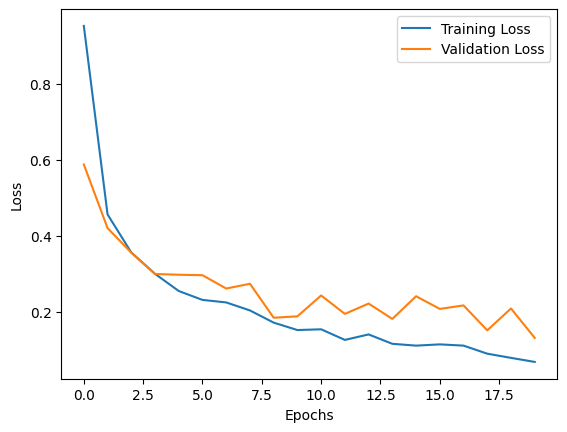

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

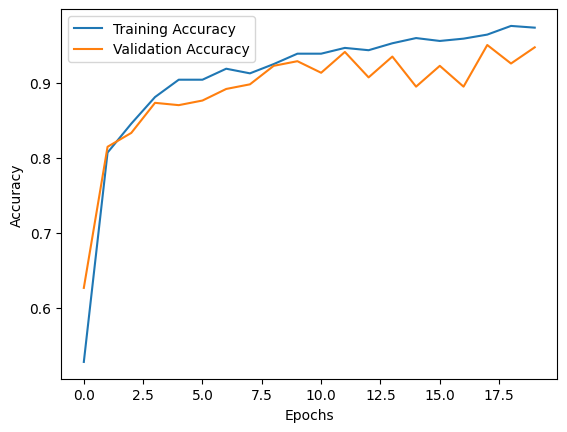

In [30]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
loss,acc = model.evaluate(train_data_generator)
print("Accuracy on Train Data:",acc)

loss,acc = model.evaluate(val_data_generator)
print("Accuracy on Test Data:",acc)

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step - accuracy: 0.9736 - loss: 0.0732
Accuracy on Train Data: 0.9729938507080078
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - accuracy: 0.9652 - loss: 0.1666
Accuracy on Test Data: 0.959876537322998


In [32]:
import pickle
import tensorflow as tf

# Assume 'model' and 'history' are from your model.fit() call

# Save the model in the recommended format
model.save('my_model.keras')

# Save the training history
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Model and training history have been saved successfully.")

Model and training history have been saved successfully.


## ***Model Predictions on CNN***

In [36]:
# Create a dictionary for mapping numeric class labels to human-readable string labels
class_label_mapping = {
    0: 'NoTumor',           
    1: 'Tumor'
    }

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


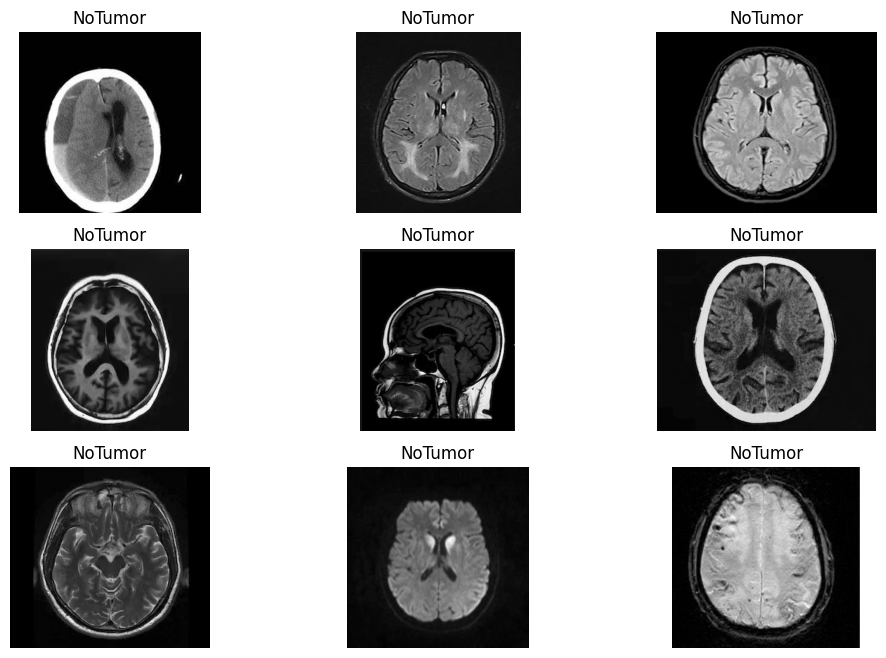

In [37]:
# Set up the figure with a 3x3 grid of subplots
plt.figure(figsize=(12, 8))

# List all files in the 'no_tumor' testing directory
files_no_tumor = os.listdir('E:/Brain Tumor Detection/Tumor_Dataset/Testing/NoTumor/')[:9]

# Initialize subplot counter
c = 1

# Loop through the first 9 images in the 'no_tumor' testing directory
for i in files_no_tumor:
    # Create a subplot
    plt.subplot(3, 3, c)

    # Read and resize the image
    img = cv2.imread('E:/Brain Tumor Detection/Tumor_Dataset/Testing/NoTumor/' + i, 0)
    img1 = cv2.resize(img, (224, 224))  # Resize images to match the model's input shape

    # Flatten and normalize the image
    img1 = img1.reshape(1, 224, 224, 1) / 255

    # Make a prediction using the model
    prediction = model.predict(img1)

    # Get the predicted class label
    predicted_class = np.argmax(prediction)

    # Display the image with the predicted class label as the title
    plt.title(class_label_mapping[predicted_class])
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Increment the subplot counter
    c += 1

# Show the subplots
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


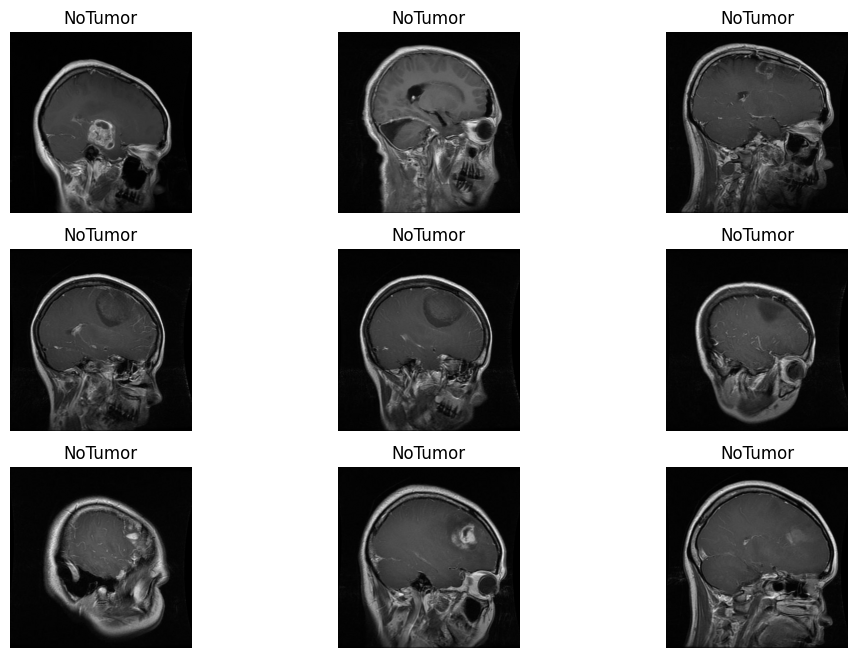

In [39]:
# Set up the figure with a 3x3 grid of subplots
plt.figure(figsize=(12, 8))

# List all files in the 'glioma_tumor' testing directory
files_tumor = os.listdir('E:/Brain Tumor Detection/Tumor_Dataset/Testing/Tumor/')[:9]

# Initialize subplot counter
c = 1

# Loop through the first 9 images in the 'tumor' testing directory
for i in files_tumor:
    # Create a subplot
    plt.subplot(3, 3, c)

    # Read and resize the image
    img = cv2.imread('E:/Brain Tumor Detection/Tumor_Dataset/Testing/Tumor/' + i, 0)
    img1 = cv2.resize(img, (224, 224))  # Resize images to match the model's input shape

    # Flatten and normalize the image
    img1 = img1.reshape(1, 224, 224, 1) / 255

    # Make a prediction using the model
    prediction = model.predict(img1)

    # Get the predicted class label
    predicted_class = np.argmax(prediction)

    # Display the image with the predicted class label as the title
    plt.title(class_label_mapping[predicted_class])
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Increment the subplot counter
    c += 1

# Show the subplots
plt.show()